# Vortex dynamics
#### Tan Beng Hau, Cavitation Lab

In this notebook I investigate the dynamics of a single and a pair of merging vortices.

## Streamfunction vorticity formulation

For completeness I will just state the main results of the vorticity formulation briefly. In the numerical calculation of the Navier-Stokes equations, the pressure is a tricky term to handle, especially as it is not known a priori. In the streamfunction vorticity formulation, the pressure term $\nabla p$ is eliminated altogether by taking the curl of the momentum equation. The momentum equation thus becomes

$$\begin{align} \omega_t + {\bf u} \cdot \nabla \omega = \nu \nabla^2 \omega,\end{align} $$

where the vorticity is defined as $\omega = \nabla\times {\bf u}$. To work with this equation, we need to update the vorticity from flow variables $u,v$. One way to access these variables is via the streamfunction formulation. Here we can express the velocities as $ u = \psi_y$ and $v = -\psi_x$. The vorticity is defined as a Poisson equation

$$\begin{align}\omega = v_x - u_y = -\psi_{xx} - \psi_{yy}.\end{align}$$

## Discretisations

The two equations we obtained are known as the streamfunction vorticity formulation because the streamfunction and vorticity are consecutively updated during the numerical solution. In the discretisations discussed in the class, we used centred differences for all the space derivatives, and forward difference for the time stepping. The vorticity transport equation is discretised as

$$ \frac{\omega_{i,j}^{n+1} - \omega_{i,j}^{n}}{\Delta t} + u_{i,j}^n  \frac{\omega_{i+1,j}^{n} - \omega_{i-1,j}^{n}}{2\Delta x} + u_{i,j}^n  \frac{\omega_{i,j+1}^{n} - \omega_{i,j-1}^{n}}{2\Delta y} = \nu\frac{\omega_{i-1,j}^n - 2\omega_{i,j}^n + \omega_{i+1,j}^n}{\Delta x^2} + \nu\frac{\omega_{i,j-1}^n - 2\omega_{i,j}^n + \omega_{i,j+1}^n}{\Delta y^2}, $$

and the Poisson equation is discretised by

$$ \frac{\psi_{i-1,j}^n - 2\psi_{i,j}^n + \psi_{i+1,j}^n }{\Delta x^2} + \frac{\psi_{i,j-1}^n - 2\psi_{i,j}^n + \psi_{i,j+1}^n }{\Delta y^2} = -\omega_{i,j}^n. $$

## Benchmarking the pressure Poisson solver

Something I learned outside the class was that for a square grid with $N$ grid points, the optimal choice for the exponent in SOR is given by

$$ \alpha = \frac{2}{1+\pi/N}. $$

Using the estimate for the best value for the SOR relaxation parameter $\alpha$ gives $\alpha = 1.9$. I tested the convergence of the pressure Poisson solver on the sample problem given in class. For most of the values values I tried, the sample $\psi$ required about 200-400 iterations, but for the optimal estimate, the code achieved convergence within 87 iterations.

The following code fragment comes from the class, which I have modified slightly to calculate the relaxation parameter from an assumed square grid.

In [1]:
from __future__ import division
from mpl_toolkits.mplot3d import Axes3D 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
err_val=0.001 #maximum relative error
maxiter=500 #maximum number of iteration 

#helper function to return the relative error
def relerror(old,new):
    i=np.where(abs(new) > 0)
    err=np.mean(((new[i]-old[i])/new[i])**2.)
    return err

def solvePoisson_SOR(p,f,deltax):
    iter=0
    beta=2/(1+ np.pi/(p.shape[0]-1))
    while True:
        pn=p.copy()
        p[:]=0.
        iter=iter+1
        
        #boundary conditions
        pn[0,:] = 0
        pn[-1,:] = 0
        pn[:,0] = 0
        pn[:,-1] = 0
        #finite difference scheme
        for i in range(1,p.shape[0]-1): 
            for j in range (1,p.shape[1]-1):
                p[i,j]=(1-beta)*pn[i,j]+0.25*beta*(deltax*deltax*f[i,j]+pn[i,j+1]+p[i,j-1]+pn[i+1,j]+p[i-1,j])
        #stop if relative error is below bound
        if relerror(pn,p)<err_val:
            break
        if iter>maxiter:
            break
    return p, iter

In [3]:
n = 101
L = 1.
dx = L/n
psi = np.zeros((n,n))
omega = np.zeros((n,n))
x = y = np.linspace(0,L,n)
X,Y = np.meshgrid(x,y)

omega[n/2, n/2] = 1./dx/dx
omega[n/3, n/3] = -2./dx/dx
omega[2*n/3, 2*n/3] = -2./dx/dx

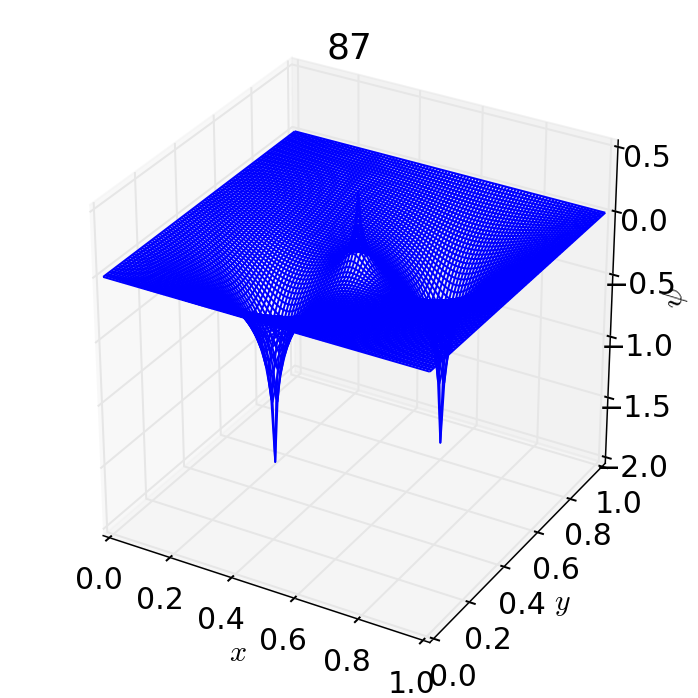

In [4]:
psi3, iter3 = solvePoisson_SOR(psi,omega,dx)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection = '3d')
ax.plot_wireframe(X,Y, psi3)
plt.rcParams['font.size'] = 15
plt.xlabel('$x$')
plt.ylabel('$y$')
ax.set_zlabel('$\\psi$')
plt.title(iter3)

### Handling the boundary conditions

I will just adopt the notation that there are $n$ points in the domain. Then periodic boundary conditions are given by

$$ \begin{align}\omega_{0,j} = \omega_{n-1,j}, \\ \omega_{i,0} = \omega_{i,n-1}. \end{align}$$

### Discretisations

The vorticity transport equation (which came from the momentum equation) is 

$$ \begin{align} \omega_{i,j}^{n+1} = \omega_{i,j}^n + \frac{\Delta t}{4\Delta x^2}  \left[ (\psi_{i,j+1}^n - \psi_{i,j-1}^n) (-\omega_{i+1,j}^n + \omega_{i-1,j}^n) + (\psi_{i+1,j}^n - \psi_{i-1,j}^n)(\omega_{i,j+1}^n - \omega_{i,j-1}^n) ) \right] + \frac{\nu\Delta t}{\Delta x^2} (\omega_{i-1,j}^n + \omega_{i+1,j}^n + \omega_{i,j-1}^n + \omega_{i,j+1}^n - 4 \omega_{i,j}^n ). \end{align} $$

In [5]:

'''
Given the vorticity and the streamfunction at some time n,
calculate them both for the next time step.
'''
def solveNS (psn,om,dt,dx, nu):
    psn, itn = solvePoisson_SOR(psn, om, dx)
    # Reimpose b.c. 
    oc = om.copy()
    oc[0, 0:] = oc[-1, 0:] # p.b.c. at left/right walls
    oc[0:, 0] = oc[0:, -1] # p.b.c. at top/bottom walls
    psn[0, 0:] = psn[-1, 0:] # p.b.c. at left/right walls
    psn[0:, 0] = psn[0:, -1] # p.b.c. at top/bottom walls    
    
    # Iterate the next omega
    A = (dt/(4*dx*dx)) * ( (psn[1:-1, 2:] - psn[1:-1, 0:-2]) *\
                         (-oc[2:,1:-1] + oc[0:-2, 1:-1]))
    B = (dt/(4*dx*dx)) * ( (psn[2:,1:-1] - psn[0:-2,1:-1]) *\
                         (oc[1:-1,2:] - oc[1:-1,0:-2]))
    C = (nu*dt/(dx*dx))* (oc[0:-2,1:-1] + oc[2:, 1:-1] + oc[1:-1,0:-2] +\
                         oc[1:-1, 2:] - 4*oc[1:-1, 1:-1])
    om[1:-1, 1:-1] = oc[1:-1, 1:-1] + A+B+C
    return psn, om


## Plotting functions 

These functions will be useful later to plot our vorticity and streamlines. 

In [10]:
'''Plotting functions'''

def streamlineplotter(X,Y,psd,dx, axe): # Plotting streamliines
    # plt.figure(figsize=(6,6))
    u1=(psd[1:-1,2:]-psd[1:-1,0:-2])/2./dx
    u2=-(psd[2:,1:-1]-psd[0:-2,1:-1])/2./dx
    uabs=np.sqrt(u1**2+u2**2)
    plt.subplot(axe)
    plt.streamplot(X[1:-1,1:-1],Y[1:-1,1:-1],u1.T,u2.T,
                   color=uabs.T, linewidth=1, arrowsize=2,
                   cmap=plt.cm.summer)
    plt.axis('off')
    plt.xlim([0,1])
    plt.ylim([0,1])

def omegaplotter(mat, axe):
    plt.subplot(axe)
    plt.imshow(mat,origin='lower')

## Diffusion of a single vortex

I made a simulation for a single vortex given by a two-dimensional Gaussian function. The momentum equation becomes a diffusion-advection equation in the vorticity $\omega$, so we would expect that an initial Gaussian peak will diffuse out in time. 

One more check for the validity of the code would just be to calculate the streamlines of the flow. By convention, the circulation around a vortex $\Gamma$ is positive when the flow is anti-clockwise. This is indeed what we obtain.

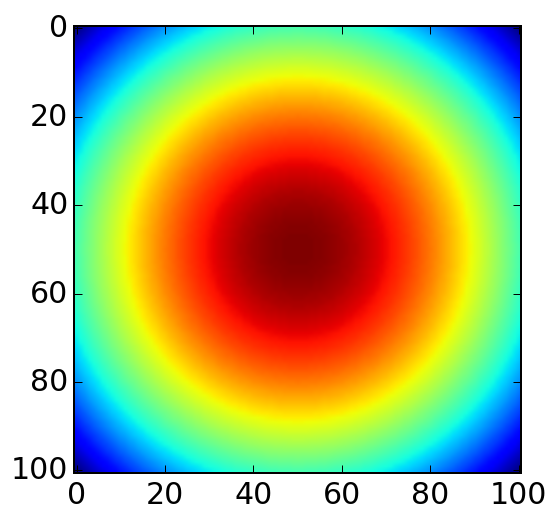

In [5]:
n = 101
L = 1.
psi = np.zeros((n,n))
omega = np.zeros((n,n))
x = y = np.linspace(0,L,n)

x0 = y0 = 0.5
a0 = 1
gamma = 1

# Vorticity grid
X,Y = np.meshgrid(x,y)
omega = (gamma/(np.pi*a0*a0)) * np.exp(-( (X-x0)**2 + (Y-y0)**2 )/a0)

plt.imshow(omega)

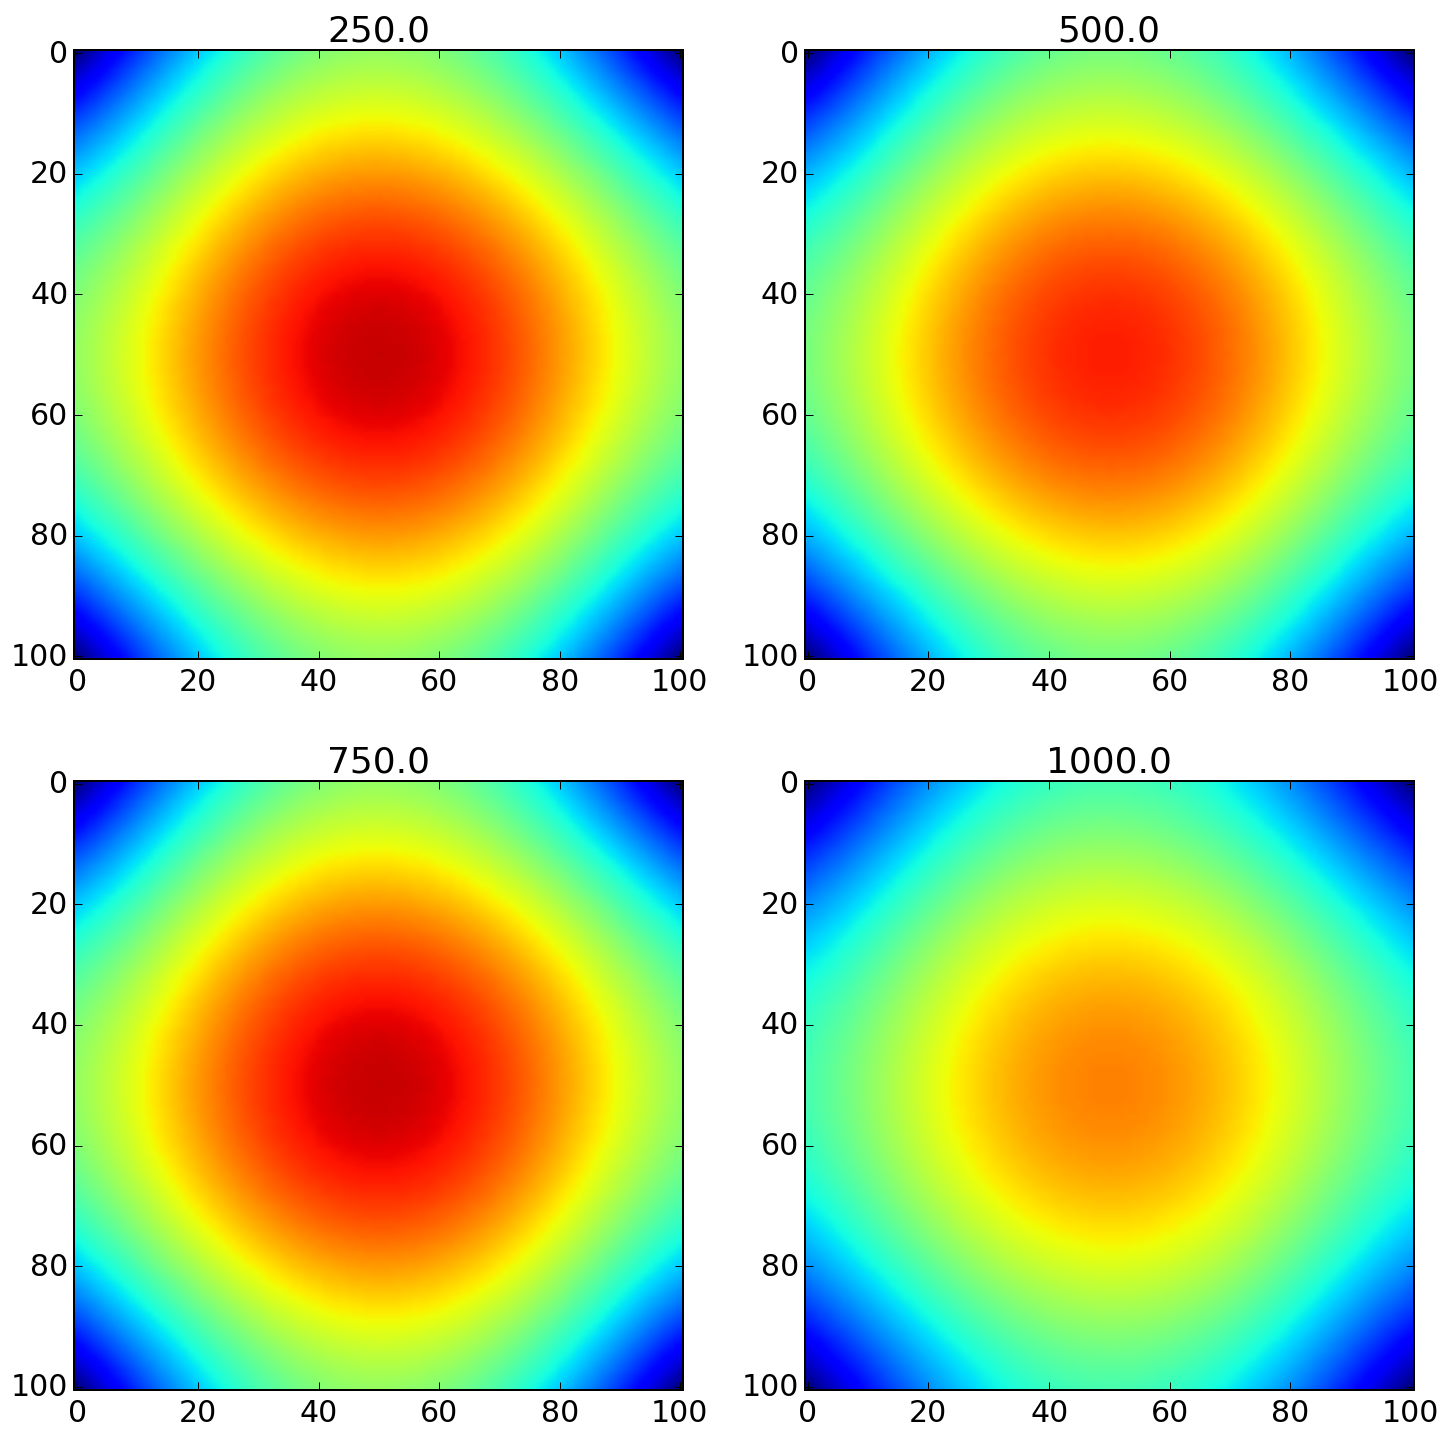

In [6]:
n = 101
L = 1.
numSteps = 1000
dt = 0.0005
# nu = 0.05
dx = L/(n-1)
psi = np.zeros((n,n))
omega = np.zeros((n,n))
x = y = np.linspace(0,L,n)

x0 = y0 = 0.5
a0 = 1
gamma = 1

# Vorticity grid
X,Y = np.meshgrid(x,y)
omega = (gamma/(np.pi*a0*a0)) * np.exp(-( (X-x0)**2 + (Y-y0)**2 )/a0)

numSteps = 1000
plt.figure(figsize=(12,12))
plt.rcParams['font.size'] = 15
for i in range(numSteps):
    psi, omega = solveNS(psi,omega,dt,dx, nu = 0.05)

    if i % round(numSteps/4) == 0:
        plt.subplot(221)
        plt.imshow(omega)
        plt.title(round(numSteps/4))
    if i % round(numSteps/2) == 0:
        plt.subplot(222)
        plt.imshow(omega)
        plt.title(round(numSteps/2))
    if i % round(3*numSteps/4) == 0:
        plt.subplot(223)
        plt.imshow(omega)
        plt.title(round(3*numSteps/4))
    if i %round(numSteps) == 0:
        plt.subplot(224)
        plt.imshow(omega)
        plt.title(round(numSteps))

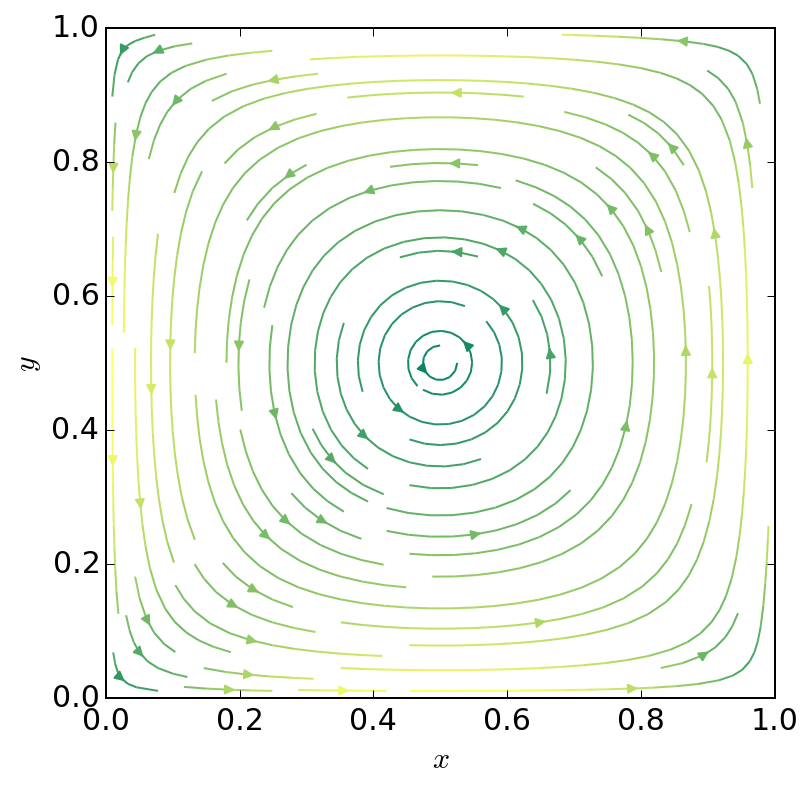

In [7]:
'''Plots the streamlines of a given streamfunction psi. '''
def vortplot(X,Y,psd,dx):
    plt.figure(figsize=(6,6))
    u1=(psd[1:-1,2:]-psd[1:-1,0:-2])/2./dx
    u2=-(psd[2:,1:-1]-psd[0:-2,1:-1])/2./dx
    uabs=np.sqrt(u1**2+u2**2)
    plt.streamplot(X[1:-1,1:-1],Y[1:-1,1:-1],u1.T,u2.T,
                   color=uabs.T, linewidth=1, arrowsize=2,
                   cmap=plt.cm.summer)#streamline plot
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('$x$')
    plt.ylabel('$y$')

vortplot(X,Y, psi,dx)

## Merger of a pair of co-rotating vortices

In this case, we have two Gaussian vortices that rotate likewise, viz. their circulations are parallel.

This problem was studied in great detail by Brandt and Nomura, J. Fluid. Mech., vol 592, 413-446 (2007). Essentially, they find that the vortices rotate as a pair, and eventually merge. At the end the combined vortex has a velocity field that has an S-shape. 

In the following simulations, the resulting distribution looks very similar to the findings of Brandt and Nomura. While playing around with the time stepping for this problem, I observed the vortex pair making a number of rotations (the frequency of which was once every $\sim 100$ timesteps) together, before the pair merged in the long time limit ($\sim 10000$ timesteps). There's a slight difference with Brandt and Nomura in that the vortex isn't precisely an S-shape but this is probably because the box is constrained by periodic boundary conditions.

To think about the physical picture, let us consider the component of velocity on the two diagonals, which I call ${\bf d}_1$ and ${\bf d}_2$. The vortices are initially oriented along ${\bf d}_1$. Between the two vortices, the velocity along ${\bf d}_2$ is zero, since the co-rotation cancels this out perfectly. A particle that is somewhere between the two vortices experiences a velocity field that is pointing purely in the direction of ${\bf d}_1$. In the end, particles at the upper right vortex or the lower left vortex are sucked towards the centre, driving the merger of the vortices. 

Meanwhile, as a whole, the two vortices possess a net angular momentum and of course rotate anticlockwise (since each has a positive circulation $\Gamma > 0$, and since their respective angular momenta don't cancel out). This is why the vortex pair rotates, while simultaneously merging. In our case at least the rate of the rotation is much faster than the rate at which the vortices merge. 

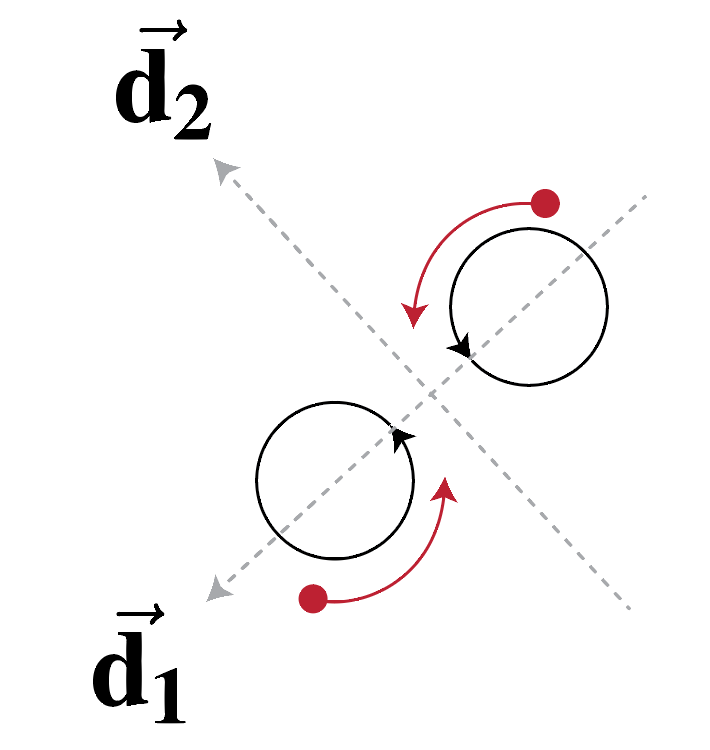

In [15]:
from IPython.display import Image
Image(filename='vortex.png') 

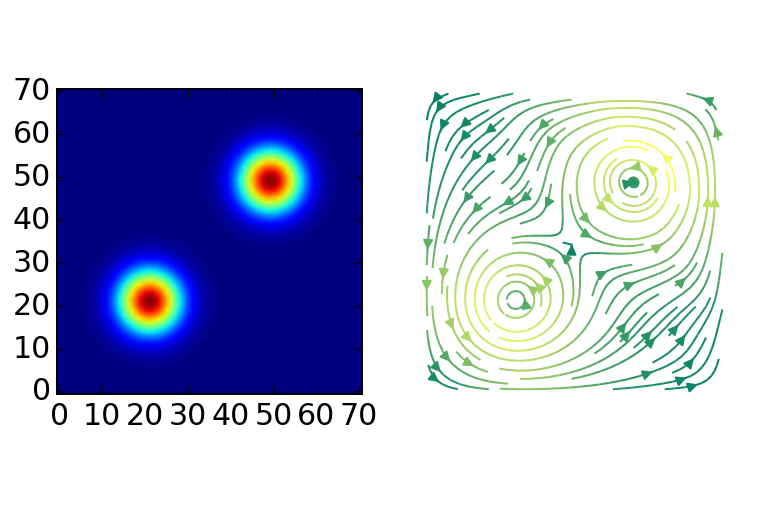

In [16]:
n = 71
L = 1.
psi3 = np.zeros((n,n))
omega3 = np.zeros((n,n))
x = y = np.linspace(0,L,n)
X,Y = np.meshgrid(x,y)

def omegaplotter(mat, axe):
    plt.subplot(axe)
    plt.imshow(mat,origin='lower')

def doubleGaussian(X,Y, x0,y0,a0,g0, x1,y1,a1,g1):
    vortex1 = (g0/(np.pi*a0*a0)) * np.exp(-( (X-x0)**2 + (Y-y0)**2 )/a0)
    vortex2 = (g1/(np.pi*a1*a1)) * np.exp(-( (X-x1)**2 + (Y-y1)**2 )/a1)
    return vortex1+vortex2

# Iterate for just one timestep, so we can look at the flow field
omega3 = doubleGaussian(X,Y, 0.3, 0.3, 0.01, 1, 0.7,0.7,0.01,1)
psi3, omega3 = solveNS(psi3,omega3,dt,dx, nu = 0.05)
omegaplotter(omega3,121)
streamlineplotter(X,Y,psi3,dx,122)
plt.axis('equal'); plt.xlim([0,1]);plt.ylim([0,1]);

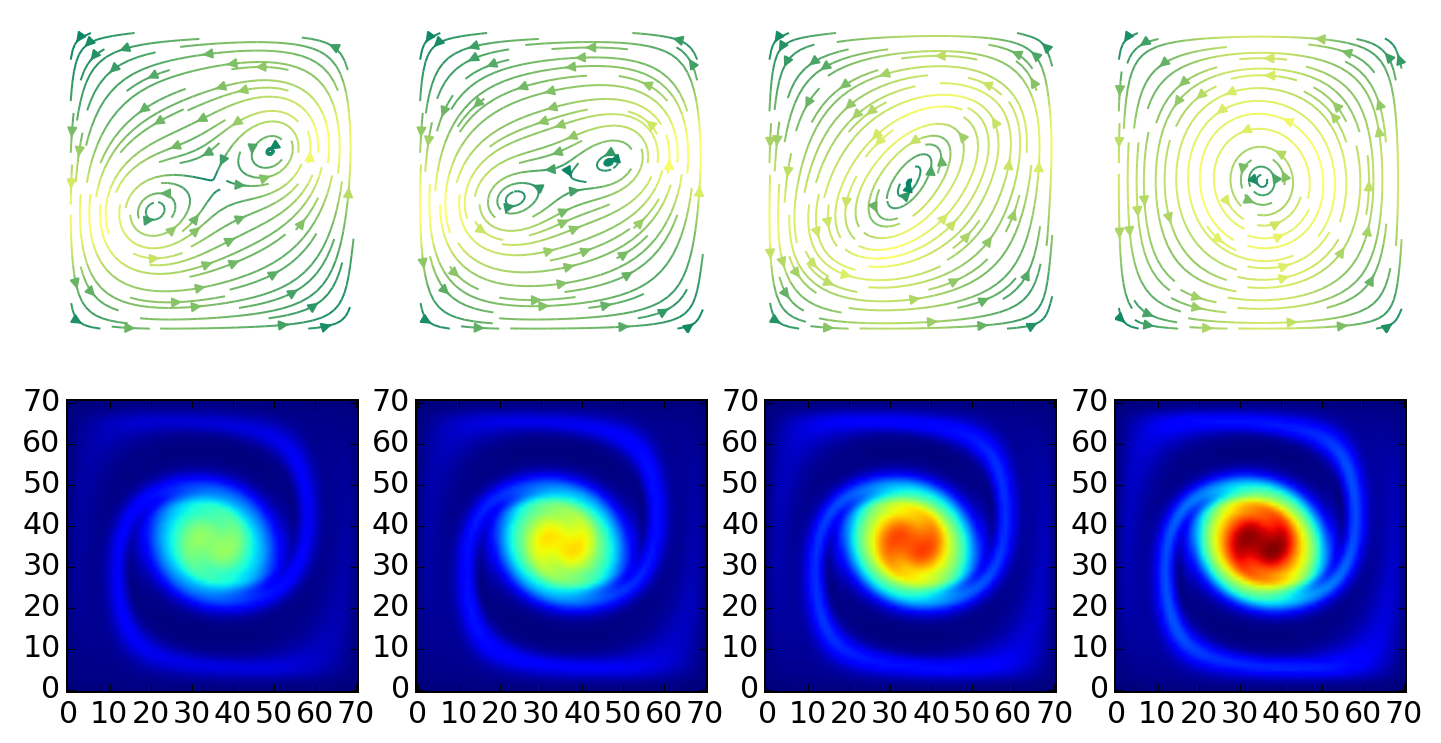

In [17]:
n = 71
L = 1.
psi4 = np.zeros((n,n))
omega4 = np.zeros((n,n))
x = y = np.linspace(0,L,n)
dt = 0.00001
dx = L/(n-1)

X,Y = np.meshgrid(x,y)
X,Y = np.meshgrid(x,y)
omega4 = doubleGaussian(X,Y, 0.3, 0.3, 0.01, 1, 0.7,0.7,0.01,1)

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

axe_list = [241, 242, 243, 244]
om_list = [245, 246, 247, 248]
'''
This for-loop advances the numerical solution by numSteps
and returns the streamlines.
'''
for n in range(len(axe_list)):
    numSteps = 2000
    for i in range(numSteps):
        psi4, omega4 = solveNS(psi4,omega4,dt,dx, nu = 0.05)

    streamlineplotter(X,Y,psi4,dx,axe_list[n])
    omegaplotter(omega4, om_list[n])

## How viscosity affects the merger of vortices

First I show how increasing the viscosity affects the merger time, using the same parameters except for a 1 order increase in magnitude of $\nu$. Essentially, the merger occurs faster when $\nu$ is increased; here the merger is completed by timestep 1800, versus approximately 8000 for the original example. 

This makes sense, because the merger of the vortices depends on the diffusion of our initial Gaussian vortices $\omega$. In the vorticity transport equation, the viscosity $\nu$ serves as a diffusion constant. 

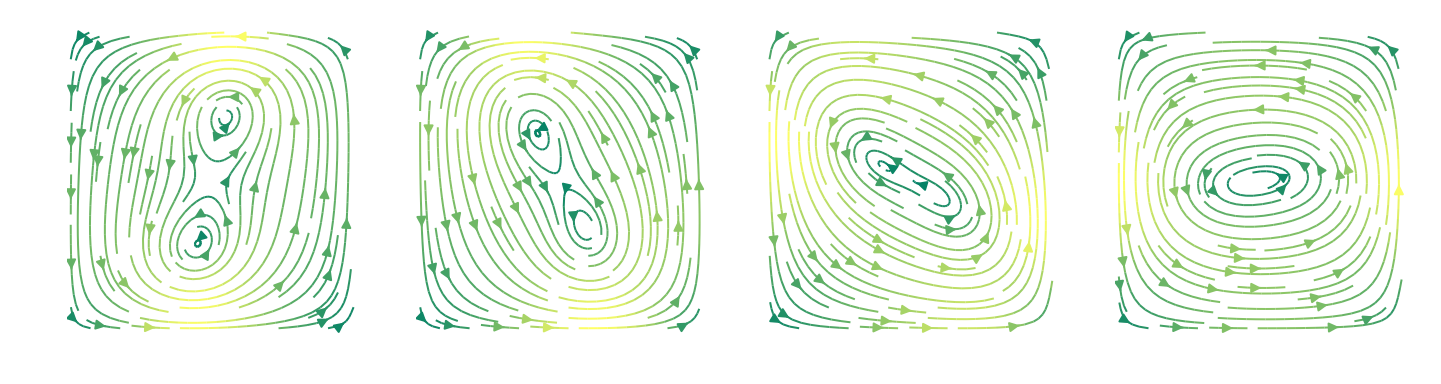

In [18]:
n = 71
L = 1.
psi5 = np.zeros((n,n))
omega5 = np.zeros((n,n))
x = y = np.linspace(0,L,n)
dt = 0.00001
dx = L/(n-1)

X,Y = np.meshgrid(x,y)
X,Y = np.meshgrid(x,y)
omega5 = doubleGaussian(X,Y, 0.3, 0.3, 0.01, 1, 0.7,0.7,0.01,1)

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

axe_list = [241, 242, 243, 244]
om_list = [245, 246, 247, 248]
'''
This for-loop advances the numerical solution by numSteps
and returns the streamlines.
'''
for n in range(len(axe_list)):
    numSteps = 450
    for i in range(numSteps):
        psi5, omega5 = solveNS(psi5,omega5,dt,dx, nu = 0.5)

    streamlineplotter(X,Y,psi5,dx,axe_list[n])
    
    # Omitted the vorticity plot because it doesn't show us anything useful
    # omegaplotter(omega5, om_list[n])

When we use a very low viscosity, what happens in our simulations is that the vortex is continuously rotating, but our Gaussian vortices don't merge, since the diffusive part of the vorticity transport equation is small. 

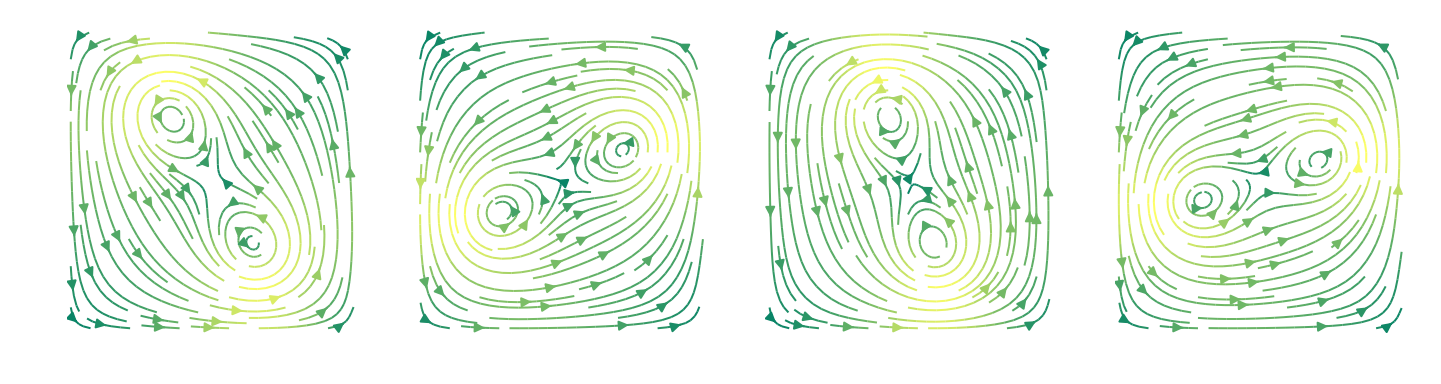

In [19]:
n = 71
L = 1.
psi6 = np.zeros((n,n))
omega6 = np.zeros((n,n))
x = y = np.linspace(0,L,n)
dt = 0.00001
dx = L/(n-1)

X,Y = np.meshgrid(x,y)
X,Y = np.meshgrid(x,y)
omega6 = doubleGaussian(X,Y, 0.3, 0.3, 0.01, 1, 0.7,0.7,0.01,1)

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

axe_list = [241, 242, 243, 244]
om_list = [245, 246, 247, 248]
'''
This for-loop advances the numerical solution by numSteps
and returns the streamlines.
'''
for n in range(len(axe_list)):
    numSteps = 1000
    for i in range(numSteps):
        psi6, omega6 = solveNS(psi6,omega6,dt,dx, nu = 0.0075)

    streamlineplotter(X,Y,psi6,dx,axe_list[n])

## Conclusions

A single vortex in periodic boundary conditions loses its vorticity over time. 

A pair of co-rotating vortices will start to rotate, given that they each (and collectively) possess angular momentum. However, the rate at which they merge is critically determined by kinematic viscosity. This is because the transport of vorticity in the vorticity streamfunction formulation is essentially a diffusion problem in which the kinematic viscosity serves as a diffusion constant. In the inviscid limit, the two vortices rotate indefinitely about a common axis, without merging. In the viscous limit, the vortices merge after rotating as a pair for some time, and the vorticity field in this case has a characteristic S-shape.

## Two counter-rotating vortices

Let us now have two counterrotating vortices, which means that one vortex has a positive circulation $+\Gamma$ and the other is negative. 

When there are two counter-rotating vortices, the region between the two vortices is *additive*, and the velocity points towards the upper left. Fluid particles - including the particles that make up the vortex - are therefore advected strongly in this direction, so we expect the vortex pair to translate towards the upper left corner, while simultaneously sustaining the rotational motion.

In the code I have removed the periodic boundary conditions. We do indeed see that the vortices translate together along the diagonal towards the upper left. 

There's a very nice Youtube video showing this translation of vortices in action:

In [20]:
from IPython.display import YouTubeVideo
YouTubeVideo("pnbJEg9r1o8 ")

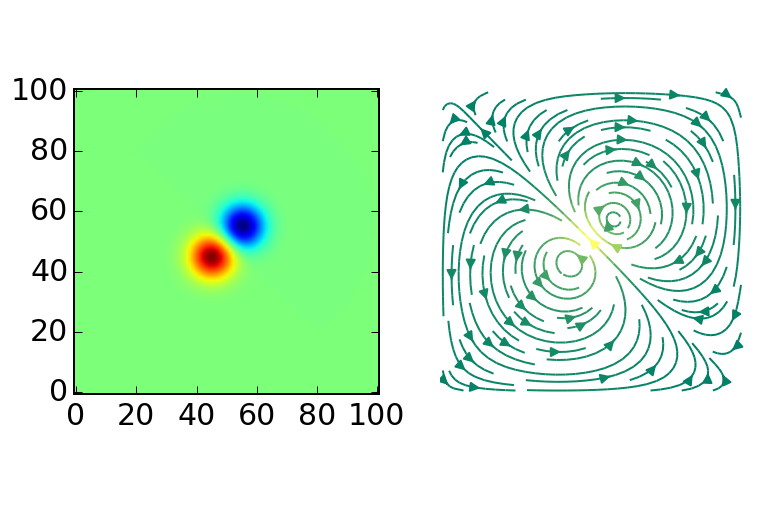

In [21]:
n = 101
L = 1.
psi2 = np.zeros((n,n))
omega2 = np.zeros((n,n))
x = y = np.linspace(0,L,n)

x0 = y0 = 0.5
a0 = 0.25
gamma = 1

X,Y = np.meshgrid(x,y)

def doubleGaussian(X,Y, x0,y0,a0,g0, x1,y1,a1,g1):
    vortex1 = (g0/(np.pi*a0*a0)) * np.exp(-( (X-x0)**2 + (Y-y0)**2 )/a0)
    vortex2 = (g1/(np.pi*a1*a1)) * np.exp(-( (X-x1)**2 + (Y-y1)**2 )/a1)
    return vortex1+vortex2

# Iterate for one time step so we can look at the streamlines
omega2 = doubleGaussian(X,Y, 0.45, 0.45, 0.005, 1, 0.55,0.55,0.005,-1)
psi2, omega2 = solveNS(psi2,omega2,dt,dx, nu = 0.05)
omegaplotter(omega2,121)
streamlineplotter(X,Y,psi2,dx,122)
plt.axis('equal'); plt.xlim([0,1]);plt.ylim([0,1]);

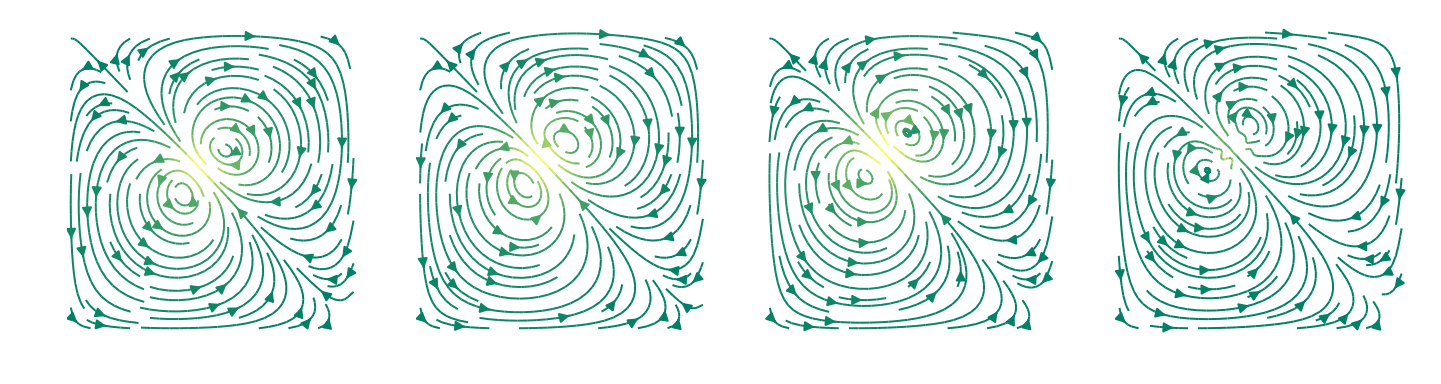

In [22]:
n = 71
L = 1.
psi2 = np.zeros((n,n))
omega2 = np.zeros((n,n))
x = y = np.linspace(0,L,n)
dt = 0.00001
dx = L/(n-1)

X,Y = np.meshgrid(x,y)


'''
A non-periodic version of our NS solver.
'''
def solveNS_np (psn,om,dt,dx, nu):
    psn, itn = solvePoisson_SOR(psn, om, dx)
    # Reimpose b.c. 
    oc = om.copy()
    oc[1:-1,0]=-2.0*psn[1:-1,1]/dx/dx
    oc[1:-1,-1]=-2.0*psn[1:-1,-2]/dx/dx
    oc[0,1:-1]=-2.0*psn[1,1:-1]/dx/dx #left wall
    oc[-1,1:-1]=-2.0*psn[-2,1:-1]/dx/dx #right wall
    psn[0, 0:] = psn[-1, 0:] = 0
    psn[0:, 0] = psn[0:, -1] = 0  
    
    # Iterate the next omega
    A = (dt/(4*dx*dx)) * ( (psn[1:-1, 2:] - psn[1:-1, 0:-2]) *\
                         (-oc[2:,1:-1] + oc[0:-2, 1:-1]))
    B = (dt/(4*dx*dx)) * ( (psn[2:,1:-1] - psn[0:-2,1:-1]) *\
                         (oc[1:-1,2:] - oc[1:-1,0:-2]))
    C = (nu*dt/(dx*dx))* (oc[0:-2,1:-1] + oc[2:, 1:-1] + oc[1:-1,0:-2] +\
                         oc[1:-1, 2:] - 4*oc[1:-1, 1:-1])
    om[1:-1, 1:-1] = oc[1:-1, 1:-1] + A+B+C
    return psn, om

def doubleGaussian(X,Y, x0,y0,a0,g0, x1,y1,a1,g1):
    vortex1 = (g0/(np.pi*a0*a0)) * np.exp(-( (X-x0)**2 + (Y-y0)**2 )/a0)
    vortex2 = (g1/(np.pi*a1*a1)) * np.exp(-( (X-x1)**2 + (Y-y1)**2 )/a1)
    return vortex1+vortex2

omega2 = doubleGaussian(X,Y, 0.45, 0.45, 0.005, 1.5, 0.55,0.55,0.005,-1.5)

plt.figure(figsize=(12,6))
plt.rcParams['font.size'] = 15

axe_list = [241, 242, 243, 244] #, 245, 246, 247, 248]
om_list = [245, 246, 247, 248]

'''
This for-loop advances the numerical solution by numSteps
and returns the streamlines.
'''
for n in range(len(axe_list)):
    numSteps = 20
    for i in range(numSteps):
        psi2, omega2 = solveNS_np(psi2,omega2,dt,dx, nu = 0.05)

    streamlineplotter(X,Y,psi2,dx,axe_list[n])
    # omegaplotter(omega2, om_list[n])